# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.333254,False,-4.036600
1,-2.580767,False,-3.174365
2,0.110417,False,-0.023928
3,-2.142098,False,-1.706643
4,-0.119242,False,-0.255492
...,...,...,...
995,-1.058446,False,-1.488079
996,-0.579523,False,-0.726904
997,-1.098309,False,-1.617708
998,-1.039810,False,-1.273360


<AxesSubplot:xlabel='v0'>

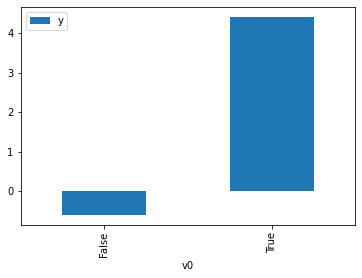

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

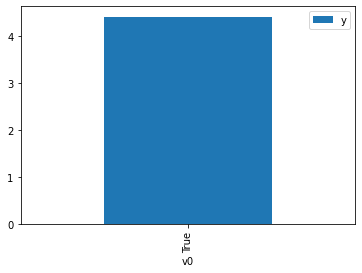

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.012520,False,-0.293696,0.515386,1.940293
1,0.340230,False,0.906081,0.399300,2.504384
2,-0.432397,False,-0.053043,0.668097,1.496789
3,-1.202346,False,-1.625096,0.858601,1.164685
4,-0.621602,False,0.260048,0.725302,1.378736
...,...,...,...,...,...
995,-0.665665,False,-0.128105,0.737711,1.355545
996,-1.462363,False,-0.895230,0.898128,1.113427
997,0.975940,False,0.845184,0.210816,4.743462
998,-0.792791,False,0.196740,0.771430,1.296293


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.880858,True,2.751596,0.058595,17.066382
1,-0.539968,True,4.673894,0.298626,3.348669
2,-0.939457,True,4.128437,0.193609,5.165054
3,0.943469,True,7.881093,0.781332,1.279865
4,-0.921393,True,2.507726,0.197685,5.058550
...,...,...,...,...,...
995,1.345061,True,6.782603,0.864050,1.157340
996,-1.151941,True,4.356264,0.150404,6.648773
997,-1.439451,True,3.908115,0.104918,9.531258
998,-0.408666,True,5.028167,0.339492,2.945575


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              5127.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        10:36:54   Log-Likelihood:                         -1374.9
No. Observations:                1000   AIC:                                      2754.
Df Residuals:                     998   BIC:                                      2764.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9434      0.025     38.013      0.000       0.895       0.992
x2             4.9962      0.054     92.832      0.000       4.891       5.102
==============================================================================
Omnibus:                        4.604   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.675
Skew:                          -0.156   Prob(JB):                       0.0966
Kurtosis:                       2.876   Cond. No.                         2.17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""